In [3]:
# ------ River imports ---------

from river import stream

# Metrics
from river.metrics import Accuracy, Precision, Recall, F1, CohenKappa, BalancedAccuracy

# Drift Detectors
from river.drift import ADWIN, KSWIN, PageHinkley, DriftRetrainingClassifier
from river.drift.binary import *

# Classifiers
from river.linear_model import LogisticRegression
from river.forest import ARFClassifier
from river.tree import HoeffdingTreeClassifier, ExtremelyFastDecisionTreeClassifier

In [4]:
# ------ Sk-learn imports -------------

# sklearn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Sklearn Metric
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score

# Others
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [5]:
# ------ Basic python lib imports ----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import mplcursors
from collections import deque
import warnings
from scipy.stats import ks_2samp

warnings.filterwarnings("ignore")

# %matplotlib inline
# mpld3.enable_notebook()

In [6]:
# ------ Get "cfpdss" data --------------------------
df_cfpdss = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss.csv"
)
df_cfpdss.head()

,c5,c6,c7,c8,c9,n0,n1,n2,n3,n4,class
0,a,a,b,a,a,0.448573,1.212644,2.555515,0.242702,0.697604,A
1,a,a,a,b,b,1.902515,-0.467349,-0.744523,-0.017156,-0.380288,A
2,a,a,a,b,b,0.825045,1.002267,1.972207,-0.790095,0.233456,B
3,a,a,a,b,b,-0.124974,0.902601,1.696092,-0.320182,0.243261,A
4,b,a,a,b,a,-1.259765,0.793134,1.547527,-2.132172,-0.788367,B


In [7]:
# ------ Get cfpdss data with missing values
df_cfpdss_missing = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss_m0.5.csv"
)
df_cfpdss_missing = df_cfpdss_missing.iloc[:, 1:]
df_cfpdss_missing.iloc[49:55]

,c5,c6,c7,c8,c9,n0,n1,n2,n3,n4,class
49,a,a,a,a,a,-0.192318,0.714631,1.188953,2.146077,1.393357,0
50,NaN,a,a,NaN,NaN,0.178767,NaN,NaN,NaN,0.269626,0
51,NaN,a,a,a,NaN,1.364684,-0.428681,NaN,1.122679,NaN,0
52,NaN,b,b,NaN,NaN,-0.878532,2.046157,4.402366,-0.633157,0.579233,0
53,NaN,NaN,NaN,a,a,0.794489,-1.089565,NaN,0.096427,NaN,1
54,NaN,NaN,a,a,NaN,NaN,NaN,NaN,0.282534,NaN,0


In [46]:
def data_encoding(data, feature_scaling=True):
    X_df = data.drop(columns="class")

    # Separating categorical and non-categorical columns
    categorical_columns = X_df.select_dtypes(include=["object"]).columns.tolist()
    X_df_categorical = X_df[categorical_columns]
    non_cat_columns = [col for col in X_df.columns if col not in categorical_columns]
    X_df_non_categorical = X_df[non_cat_columns]

    # Record the indices of missing values for each categorical feature
    missing_indices = {
        col: X_df_categorical[col].index[X_df_categorical[col].isna()].tolist()
        for col in categorical_columns
    }

    # Impute NaN values in categorical features with the most frequent value from the same column
    X_df_categorical = X_df_categorical.apply(
        lambda col: col.fillna(
            col.mode()[0] if not col.mode().empty else col.value_counts().index[0]
        )
    )

    # One hot encoding - Categorical data
    encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
    one_hot_encoded = encoder.fit_transform(X_df_categorical)
    columns = encoder.get_feature_names_out(categorical_columns)
    X_df_cat_one_hot = pd.DataFrame(
        one_hot_encoded, columns=columns, index=X_df_categorical.index
    )

    # Replace the imputed values back with NaNs in the encoded DataFrame
    for col, indices in missing_indices.items():
        for index in indices:
            cols_to_check = [c for c in X_df_cat_one_hot.columns if c.startswith(col)]
            for c in cols_to_check:
                X_df_cat_one_hot.at[index, c] = np.nan

    # Feature scaling numerical data/non-categorical data
    if feature_scaling:
        scaler = MinMaxScaler()
        X_df_non_categorical = pd.DataFrame(
            scaler.fit_transform(X_df_non_categorical),
            columns=X_df_non_categorical.columns,
            index=X_df_non_categorical.index,
        )

    # Concatenate categorical and non-categorical data
    X_df_encoded = pd.concat(
        [
            X_df_cat_one_hot,
            X_df_non_categorical,
            # X_df_categorical  # Re-add the original categorical columns with NaNs
        ],
        axis=1,
    )

    # Encoding the target variable
    y_df = data[["class"]]
    y_encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
    y_one_hot = y_encoder.fit_transform(y_df)
    y_encoded = pd.Series(y_one_hot.ravel())

    return X_df_encoded, y_encoded

In [47]:
# ------ Encode missing and non-missing ddata
# X_df_encoded, y_encoded =  data_encoding(df_cfpdss)
X_df_encoded_m, y_encoded_m = data_encoding(df_cfpdss_missing)

In [48]:
X_df_encoded_m.isna().sum()

c5_b    6545
c6_b    6418
c7_b    6433
c8_b    6485
c9_b    6632
n0      6514
n1      6495
n2      6474
n3      6488
n4      6541
dtype: int64

In [43]:
X_df_encoded_m.head()

,c5_b,c6_b,c7_b,c8_b,c9_b,n0,n1,n2,n3,n4,c5,c6,c7,c8,c9
0,0.0,0.0,1.0,0.0,0.0,0.530356,0.598345,0.519161,0.478557,0.620371,a,a,b,a,a
1,0.0,0.0,0.0,1.0,1.0,0.672618,0.423329,0.442055,0.449888,0.458838,a,a,a,b,b
2,0.0,0.0,0.0,1.0,1.0,0.567192,0.576429,0.505532,0.364614,0.550814,a,a,a,b,b
3,0.0,0.0,0.0,1.0,1.0,0.474236,0.566046,0.499081,0.416457,0.552283,a,a,a,b,b
4,1.0,0.0,0.0,1.0,0.0,0.363202,0.554642,0.495610,0.216550,0.397683,b,a,a,b,a


In [8]:
def detect_drift_using_KS(window, window_size):
    """
    Detects drift in the current window using the Kolmogorov-Smirnov test.

    Parameters:
        window (np.array): The current window of data points.
        window_size (int): The size of the rolling window.

    Returns:
        tuple: (bool, str) indicating whether drift is detected and the type of drift.
    """
    first_half = window[: window_size // 2]
    second_half = window[window_size // 2 :]
    ks_stat, p_value = ks_2samp(first_half, second_half)

    if p_value < 0.001:
        mean_diff = np.mean(second_half) - np.mean(first_half)
        if np.abs(mean_diff) > np.std(window):
            return True, "Sudden Drift"
        elif mean_diff > 0:
            return True, "Linear Drift"
        else:
            return True, "Gradual Drift"

    return False, None

In [9]:
def detect_feature_drift(feature_data, window_size=100, trim_stddev=1):
    """
    Detects feature drift in the given feature data using a rolling window approach.

    Parameters:
        feature_data (pd.Series): The feature data to monitor for drift.
        window_size (int): The size of the rolling window.
        trim_stddev (float): The number of standard deviations to trim data points.

    Returns:
        drift_points (list): Indices where drift is detected.
        drift_types (list): Types of drift detected at each drift point.
        moving_averages (pd.Series): Moving averages of the feature data with corresponding indices.
    """
    window_x = deque(maxlen=window_size)
    drift_points = []
    drift_types = []
    moving_avg = pd.Series(dtype=float)

    # Initialize the rolling window with the first window_size data points
    window_x.extend(feature_data.head(window_size))
    moving_avg[window_size - 1] = np.mean(window_x)

    for idx, xi in enumerate(feature_data[window_size:], start=window_size):
        # Add the new data point to the rolling window
        window_x.append(xi)

        # Trim the window values using the separate function
        # window_x = trim_window_values(window_x, trim_stddev)

        # Detect drift using the separate function
        drift_detected, drift_type = detect_drift_using_KS(
            np.array(window_x), window_size
        )

        if drift_detected:
            drift_points.append(idx)
            drift_types.append(drift_type)

        moving_avg[idx] = np.mean(window_x)

    return drift_points, drift_types, moving_avg


# dp, dt, ma = detect_feature_drift(X_df["n0"])
# len(dp)

In [10]:
def plot_feature_drift(feature_name, feature_data, window_size=300):
    plt.figure(figsize=(10, 6))
    plt.scatter(feature_data.index, feature_data, marker="o")

    moving_mean = feature_data.rolling(window=window_size).mean()
    plt.plot(
        feature_data.index,
        moving_mean,
        color="black",
        linestyle="-",
        label=f"{feature_name} Moving Mean",
    )

    drift_points, drift_types, moving_avg = detect_feature_drift(
        feature_data, window_size, 3
    )

    # plt.plot(moving_avg.index, moving_avg, color='orange', linestyle='-', label=f'{feature} Moving Mean with trimming')

    drift_type_temp_label = []
    for idx, drift_point in enumerate(drift_points):
        drift_type = drift_types[idx]
        color = (
            "red"
            if drift_type == "Sudden Drift"
            else "orange" if drift_type == "Linear Drift" else "blue"
        )
        plt.axvline(
            x=drift_point,
            color=color,
            linestyle="--",
            label=f"{drift_type}" if drift_type not in drift_type_temp_label else "",
        )
        drift_type_temp_label.append(drift_type)

    plt.title(f"{feature_name} vs. Time")
    plt.xlabel("Time")
    plt.ylabel(f"{feature_name}")
    plt.grid(True)
    plt.xticks(np.arange(0, len(feature_data), 1000))
    plt.legend()
    plt.show()

    # print(f"Feature: {feature_name}")
    # for dp, dt in zip(drift_points, drift_types):
    #     print(f"Drift detected at index {dp}: {dt}")


plot_feature_drift("n0", X_df["n0"])

NameError: name 'X_df' is not defined

In [ ]:
for feature in non_cat_columns:
    plot_feature_drift(feature, X_df[feature])

In [ ]:
for feature in X_df_cat_one_hot.columns:
    plot_feature_drift(feature, X_df_cat_one_hot[feature])

In [ ]:
X_df_encoded_m.isna().sum()

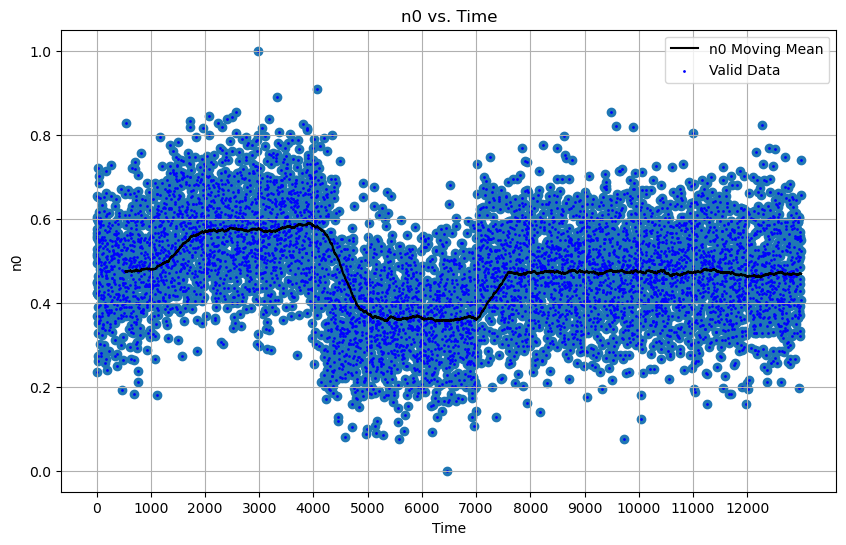

In [43]:
def plot_feature_drift(feature_name, feature_data, window_size=300):
    plt.figure(figsize=(10, 6))
    plt.scatter(feature_data.index, feature_data, marker="o")

    # moving_mean = feature_data.rolling(window=window_size).mean()

    # drift_points, drift_types, moving_avg = detect_feature_drift(
    #     feature_data, window_size, 3
    # )
    valid_data = feature_data.dropna()
    moving_mean = valid_data.rolling(window=window_size).mean()
    plt.plot(
        valid_data.index,
        moving_mean,
        color="black",
        linestyle="-",
        label=f"{feature_name} Moving Mean",
    )

    nan_data = feature_data[feature_data.isna()]
    plt.scatter(
        valid_data.index, valid_data, marker="o", s=1, color="blue", label="Valid Data"
    )

    # if not nan_data.empty:
    #    plt.scatter(nan_data.index, [0.5] * len(nan_data.index), marker='o', s=1, color='green', label='Missing Data (None/NaN)')

    # print(nan_data)
    # # plt.plot(moving_avg.index, moving_avg, color='orange', linestyle='-', label=f'{feature} Moving Mean with trimming')
    # print(nan_data.index)
    # drift_type_temp_label = []
    # if not nan_data.empty:
    #     for idx in list(nan_data.index):
    #         # drift_type = drift_types[idx]
    #         plt.axvline(
    #             x=idx,
    #             color="green",
    #             linestyle="--",
    # label=f"{drift_type}" if drift_type not in drift_type_temp_label else "",
    # )
    # drift_type_temp_label.append(drift_type)

    plt.title(f"{feature_name} vs. Time")
    plt.xlabel("Time")
    plt.ylabel(f"{feature_name}")
    plt.grid(True)
    plt.xticks(np.arange(0, len(feature_data), 1000))
    plt.legend()
    plt.show()

    # print(f"Feature: {feature_name}")
    # for dp, dt in zip(drift_points, drift_types):
    #     print(f"Drift detected at index {dp}: {dt}")


plot_feature_drift("n0", X_df_encoded_m["n1"])

<Axes: >

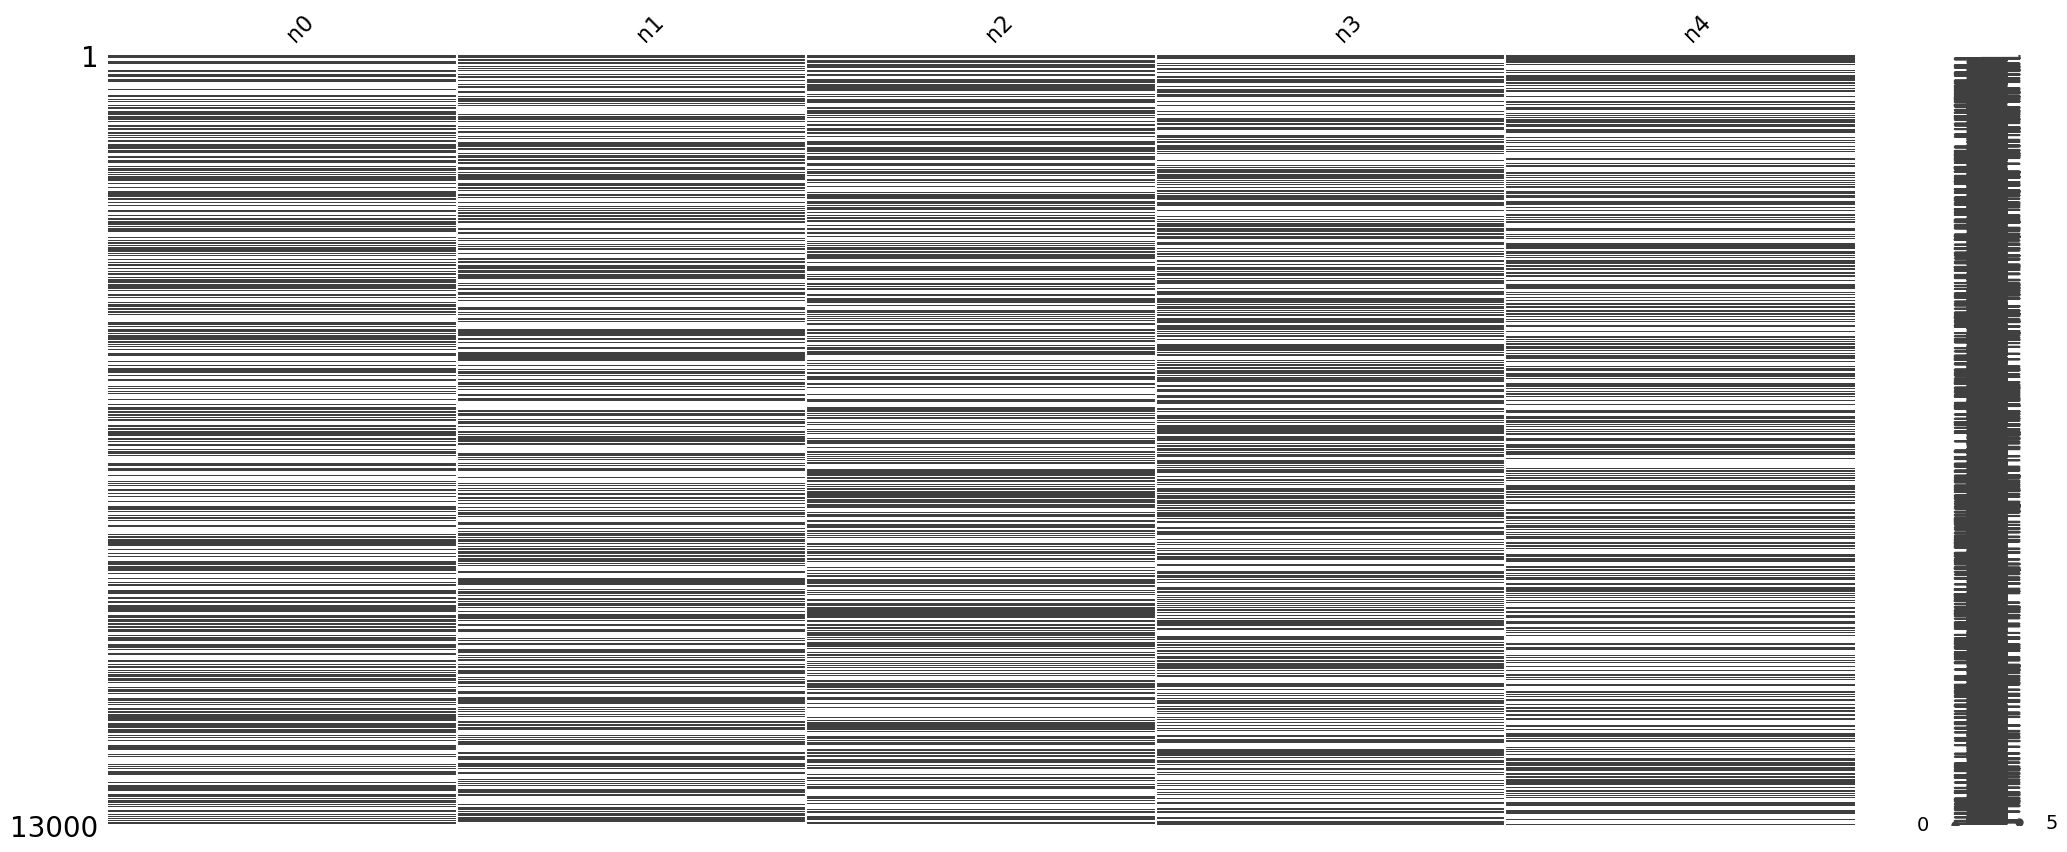

In [31]:
import missingno as msno

# Assuming X_df_encoded is your DataFrame
msno.matrix(
    X_df_encoded_m[X_df_encoded_m.select_dtypes(include=["float"]).columns.tolist()],
    filter="bottom",
)

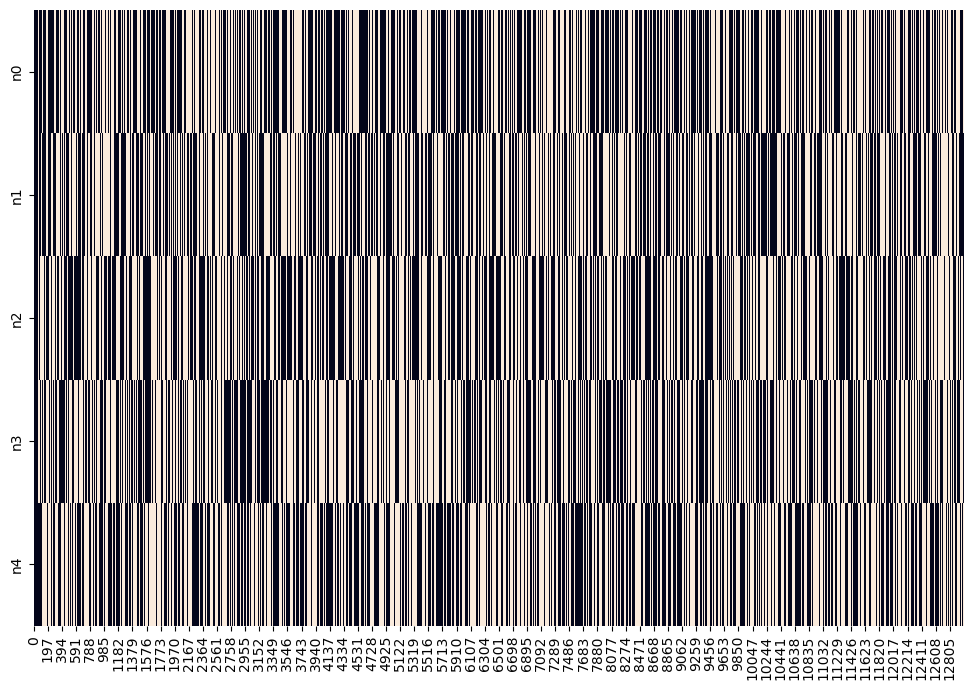

In [32]:
# Heat Map for missing data

# Assuming X_df_encoded is your DataFrame
plt.figure(figsize=(12, 8))
sns.heatmap(
    X_df_encoded_m[X_df_encoded_m.select_dtypes(include=["float"]).columns.tolist()]
    .isna()
    .transpose(),
    cbar=False,
)
plt.show()

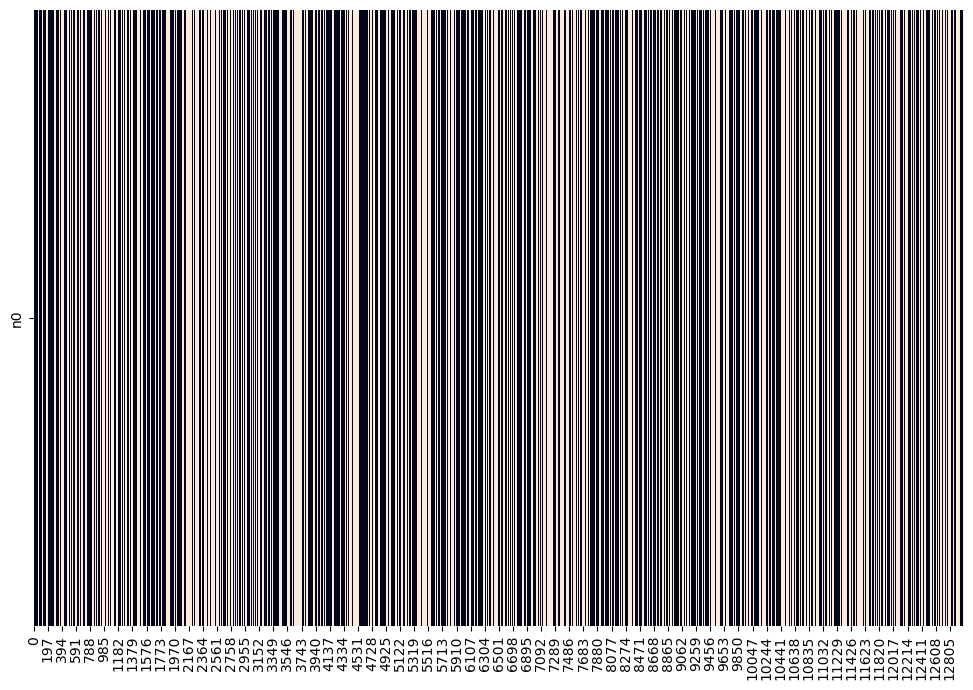

In [40]:
# missigness heat map for n0
plt.figure(figsize=(12, 8))
sns.heatmap(
    X_df_encoded_m[["n0"]].isna().transpose(),
    cbar=False,
)
plt.show()

In [90]:
import importlib
import DataMissingness

importlib.reload(DataMissingness)

<module 'DataMissingness' from 'C:\\Users\\HP\\Desktop\\github-aditya0by0\\stream-viz\\notebooks\\DataMissingness.py'>

In [ ]:
%run DataMissingness.py

In [91]:
def calculate_missigness_score(X_df_m, window_size=100):
    missigness_detector = DataMissingness.MissingnessDetector(window_size=100)
    for idx, xi in X_df_m.iterrows():
        missigness_detector.update(xi.to_dict(), idx=idx)

    return missigness_detector.get_results()


result = calculate_missigness_score(X_df_encoded_m)

In [95]:
# len(result['MAR'])
result["MNAR"].head()

,c5_b,c6_b,c7_b,c8_b,c9_b,n0,n1,n2,n3,n4,mean
99,0.21,0.23,0.23,0.17,0.21,0.21,0.13,0.21,0.19,0.22,0.201
100,0.21,0.21,0.22,0.17,0.21,0.21,0.13,0.22,0.2,0.25,0.203
101,0.28,0.24,0.2,0.18,0.23,0.22,0.13,0.21,0.19,0.24,0.212
102,0.26,0.25,0.24,0.18,0.21,0.24,0.13,0.21,0.19,0.24,0.215
103,0.3,0.26,0.23,0.2,0.23,0.25,0.13,0.24,0.19,0.27,0.23


In [81]:
len(result["MCAR (Random Test)"])

12901

In [82]:
len(result["MNAR"])

12901

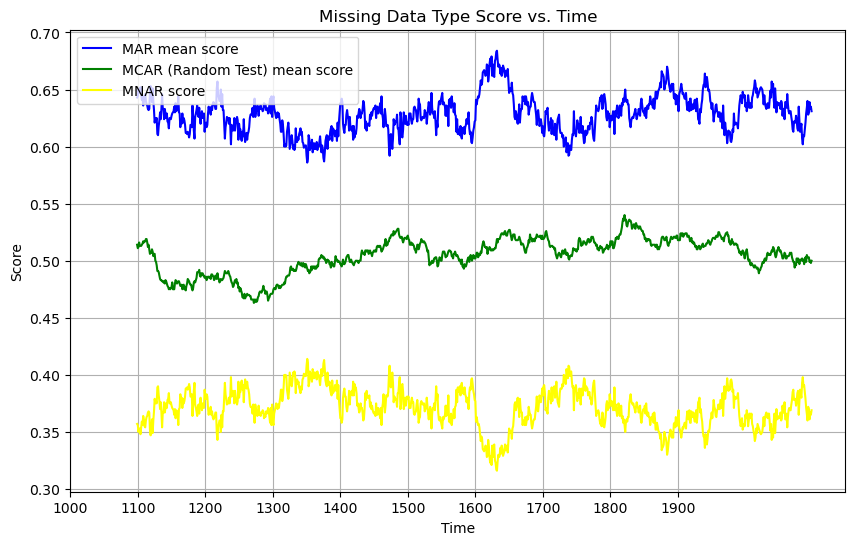

In [96]:
# Assuming result is your dictionary containing MAR, MCAR (Random Test), and MNAR scores
def plot_missigness(result, start_tp=0, end_tp=1000):
    # Plot MAR mean score
    MAR_df = result["MAR"].iloc[start_tp:end_tp]
    MCAR_df = result["MCAR (Random Test)"].iloc[start_tp:end_tp]
    MNAR_df = result["MNAR"].iloc[start_tp:end_tp]

    plt.figure(figsize=(10, 6))
    plt.plot(MAR_df.index, MAR_df["mean"], color="blue", label="MAR mean score")

    # Plot MCAR (Random Test) mean score
    plt.plot(
        MCAR_df.index,
        MCAR_df["mean"],
        color="green",
        label="MCAR (Random Test) mean score",
    )

    # Plot MNAR score
    plt.plot(MNAR_df.index, MNAR_df["mean"], color="yellow", label="MNAR score")

    plt.title("Missing Data Type Score vs. Time")
    plt.xlabel("Time")
    plt.ylabel("Score")
    plt.grid(True)
    plt.xticks(
        np.arange(start_tp, end_tp, (end_tp - start_tp) // 10)
    )  # Assuming 'MAR' is used as the index for x-axis ticks
    plt.legend()
    plt.show()


plot_missigness(result, start_tp=1000, end_tp=2000)